In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import snap

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.decomposition import PCA

from sklearn.cluster import DBSCAN
from sklearn import metrics

%matplotlib inline

In [2]:
features = pd.read_csv('followers_network.emb', sep=' ',header=None,skiprows=1)
features.head()

,0,1,2,3,4,5,6,7,8
0,58457,-0.919212,0.435673,-1.02362,-2.30432,-1.336690,-0.382707,0.179317,1.104300
1,58419,-1.132250,0.723289,-1.30977,-2.90061,-1.756550,-0.378315,0.269038,1.422520
2,58594,-1.081880,0.822349,-1.01458,-2.22133,-0.779843,-0.412698,0.231987,0.922787
3,226232,-1.427300,1.068220,-1.28929,-2.24100,-0.494674,-0.759746,0.388913,1.573620
4,63267,-1.219120,0.844997,-1.34246,-2.25884,-0.279648,-0.603148,0.047866,1.466380


In [3]:
nodes = pd.read_csv('data/followers_network_nodes.csv', sep='\t')
nodes.head()

/home/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,content,type,id_node
0,1,gxgcollective,user,2964555295
1,2,1509346839.0,post,1636842385063323219
2,3,1509326008.0,post,1636667639059249501
3,4,1509235346.0,post,1635907116583816031
4,5,1509228990.0,post,1635853795965600449


In [4]:
data = nodes.merge(features, left_on='id', right_on=0)
data.head()

,id,content,type,id_node,0,1,2,3,4,5,6,7,8
0,1,gxgcollective,user,2964555295,1,-1.497300,0.452546,-2.60750,-3.43708,-0.803582,-0.303468,-0.084647,1.646120
1,2,1509346839.0,post,1636842385063323219,2,-0.926499,0.241510,-1.72731,-2.23117,-0.506225,-0.320586,-0.049705,0.938801
2,3,1509326008.0,post,1636667639059249501,3,-1.057010,0.393636,-1.80431,-2.25517,-0.374776,-0.193187,-0.092823,1.180580
3,4,1509235346.0,post,1635907116583816031,4,-0.901383,0.258186,-1.75262,-2.19285,-0.425237,-0.242821,-0.145329,1.035950
4,5,1509228990.0,post,1635853795965600449,5,-0.907380,0.334749,-1.66251,-2.10060,-0.538954,-0.110745,-0.227679,0.940492


In [5]:
pca = PCA(n_components=2)
X_red = pca.fit_transform(data[range(1,9)])

In [6]:
sum(pca.explained_variance_ratio_)

0.41569326879968016

In [7]:
data = pd.concat([data, pd.DataFrame(X_red, columns=['r1','r2'])], axis=1)

In [8]:
data.head()

,id,content,type,id_node,0,1,2,3,4,5,6,7,8,r1,r2
0,1,gxgcollective,user,2964555295,1,-1.497300,0.452546,-2.60750,-3.43708,-0.803582,-0.303468,-0.084647,1.646120,0.977918,0.098016
1,2,1509346839.0,post,1636842385063323219,2,-0.926499,0.241510,-1.72731,-2.23117,-0.506225,-0.320586,-0.049705,0.938801,-0.500604,-0.005636
2,3,1509326008.0,post,1636667639059249501,3,-1.057010,0.393636,-1.80431,-2.25517,-0.374776,-0.193187,-0.092823,1.180580,-0.412777,0.130215
3,4,1509235346.0,post,1635907116583816031,4,-0.901383,0.258186,-1.75262,-2.19285,-0.425237,-0.242821,-0.145329,1.035950,-0.518488,0.031149
4,5,1509228990.0,post,1635853795965600449,5,-0.907380,0.334749,-1.66251,-2.10060,-0.538954,-0.110745,-0.227679,0.940492,-0.677375,0.095665


In [9]:
users = data[data['type'] == 'user']
tags = data[data['type'] == 'tag']
posts = data[data['type'] == 'post']

In [10]:
def getStructuralMetrics(X, K):
    silhouette = []
    inertia = []

    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=17).fit(X)
        s = silhouette_score(X, kmeans.labels_)
        i = kmeans.inertia_
        silhouette.append(s)
        inertia.append(i)
        
    return [silhouette, inertia]

In [58]:
def plotClusters(data, K, centroids, pcaComp = False):
    plt.figure(figsize=(12,12))
    for c in range(K):
        cluster = data[data['cluster'] == c]
        if pcaComp:
            plt.scatter(cluster['r1'], cluster['r2'], marker='.', label=c)
        else:
            plt.scatter(cluster[1], cluster[2], marker='.', label=c)
            plt.scatter(centroids[c][0], centroids[c][1], marker='o', color='black')
    plt.legend()

## 1. User features extraction and direct clustering

Apply usual methodology to extract communities of users, based on their feature representation in the complete network.

In [12]:
users.drop(['type',0], axis=1, inplace=True)

/home/anaconda2/lib/python2.7/site-packages/pandas/core/frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


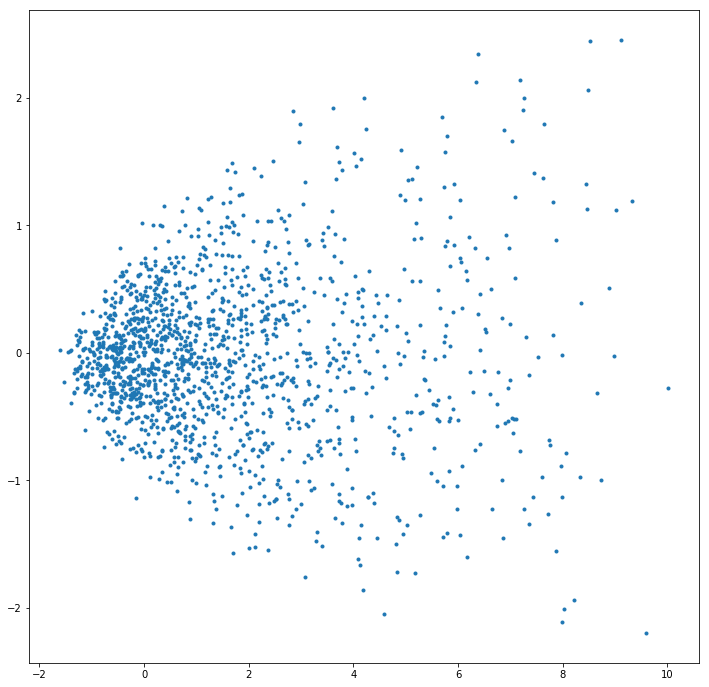

In [13]:
plt.figure(figsize=(12,12))
plt.scatter(users['r1'], users['r2'], marker='.')

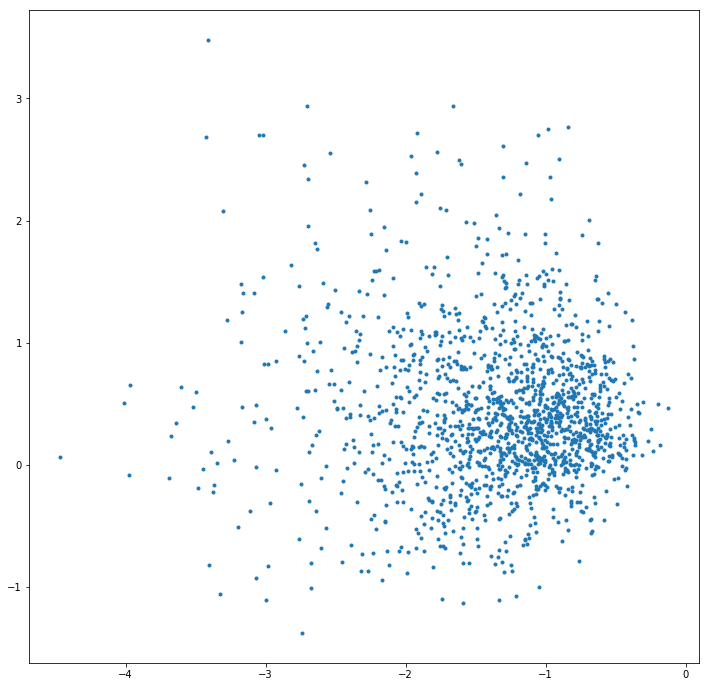

In [14]:
plt.figure(figsize=(12,12))
plt.scatter(users[1], users[2], marker='.')

In [15]:
K = range(2, 15)
s, i = getStructuralMetrics(users[range(1,9)], K)

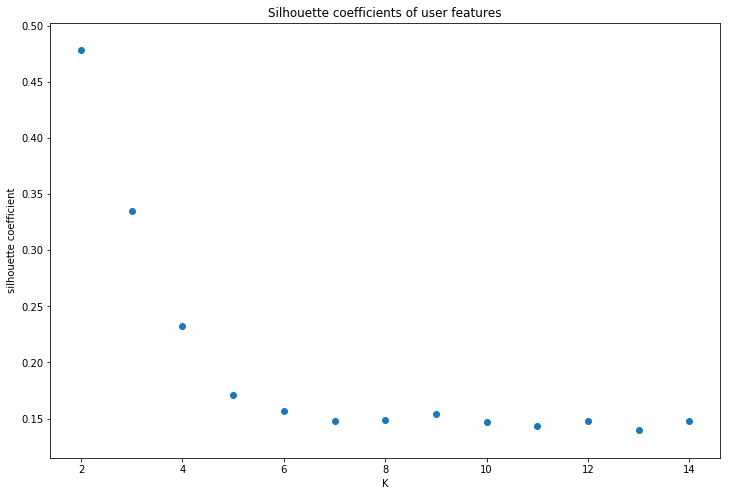

In [16]:
plt.figure(figsize=(12,8))
plt.title('Silhouette coefficients of user features')
plt.xlabel('K')
plt.ylabel('silhouette coefficient')
plt.scatter(K, s)

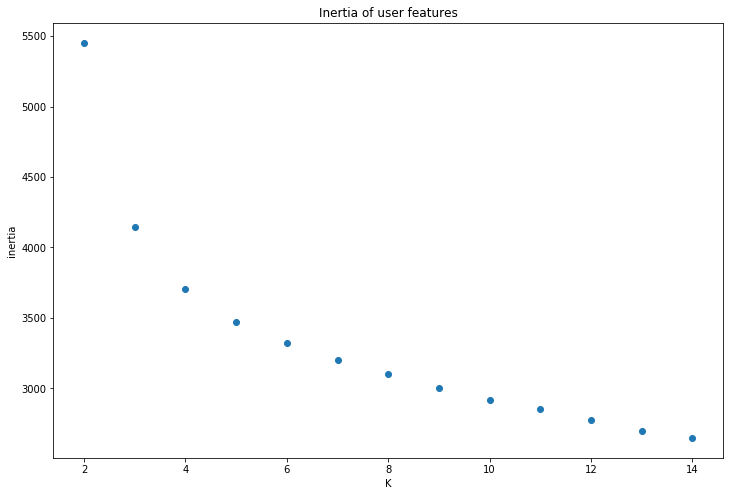

In [17]:
plt.figure(figsize=(12,8))
plt.title('Inertia of user features')
plt.xlabel('K')
plt.ylabel('inertia')
plt.scatter(K, i)

In [18]:
K_user = 6
kmeans = KMeans(n_clusters=K_user, random_state=17, n_init=15, init='random').fit(users[range(1,9)])
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

In [19]:
users['cluster'] = labels

/home/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


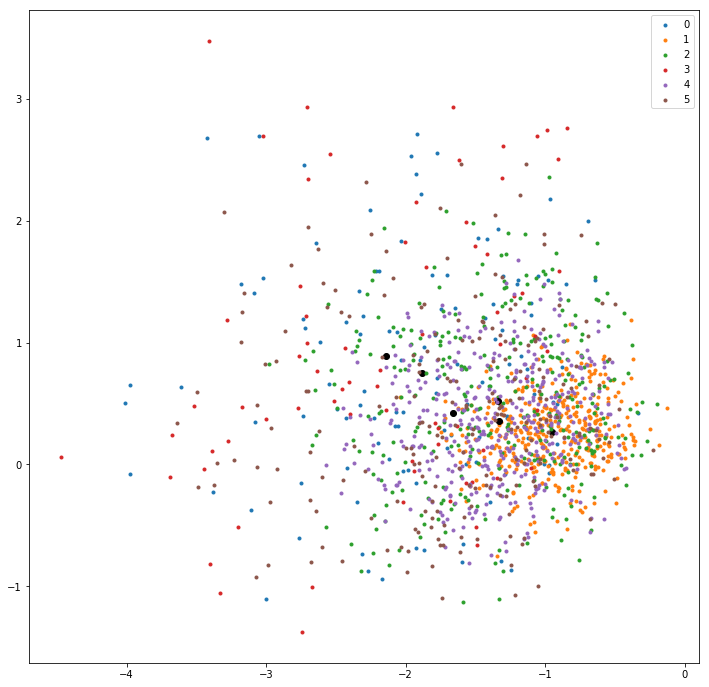

In [20]:
plotClusters(users, K_user, centroids)

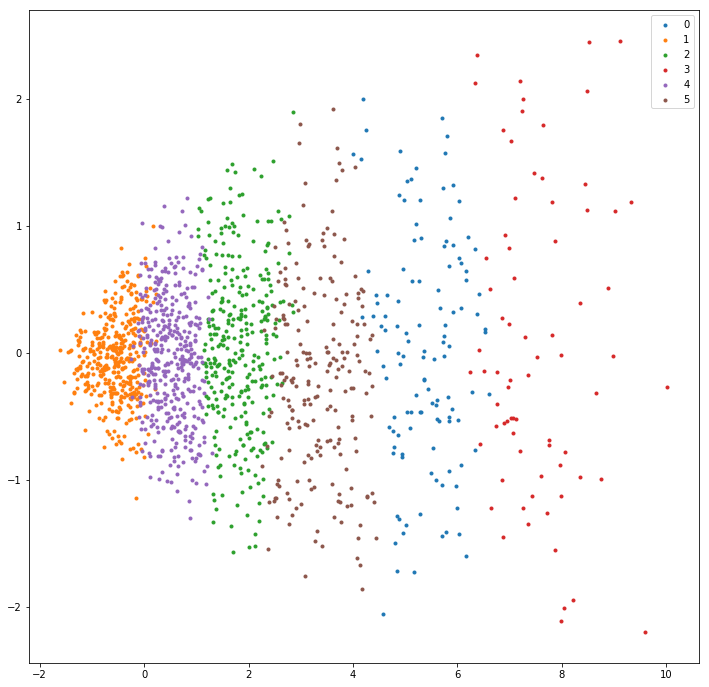

In [21]:
plotClusters(users, K_user, centroids, pcaComp=True)

In [22]:
users[['id','id_node','content','r1','r2','cluster']].to_csv('output/clustering_users.csv', index=None)

## 2. Tag features extraction and topics

Extract tag features and cluster them to define the topics

In [23]:
tags.drop(['type',0], axis=1, inplace=True)

In [24]:
tags.shape

(9201, 13)

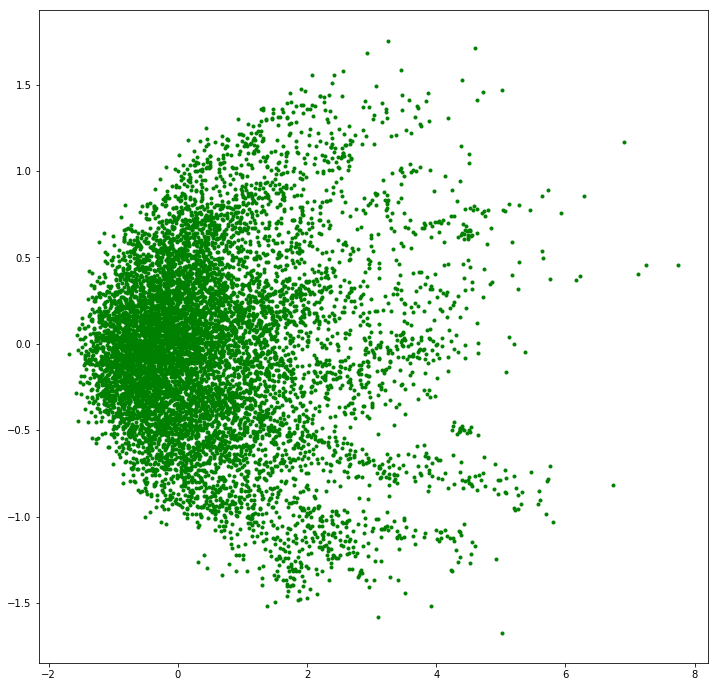

In [25]:
plt.figure(figsize=(12,12))
plt.scatter(tags['r1'], tags['r2'], marker='.', color='green')

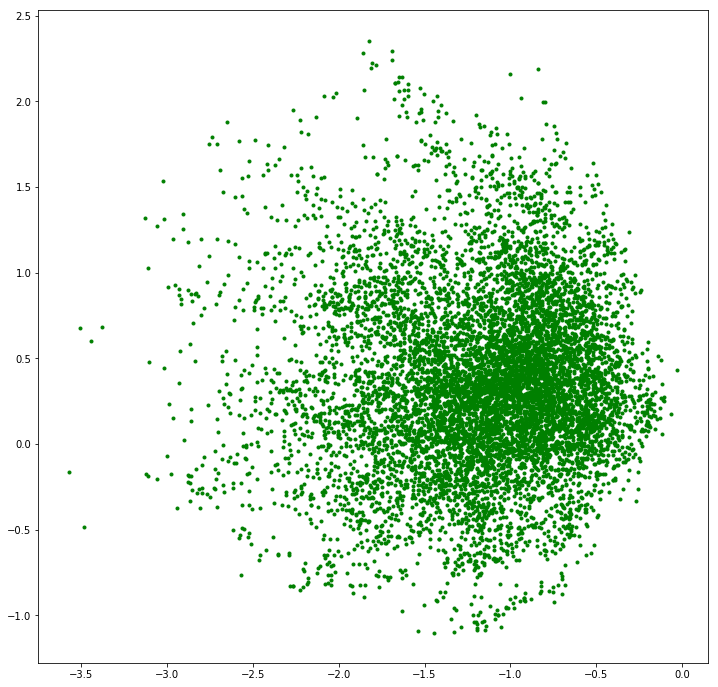

In [26]:
plt.figure(figsize=(12,12))
plt.scatter(tags[1], tags[2], marker='.', color='green')

In [27]:
K = range(2, 15)
s, i = getStructuralMetrics(tags[range(1,9)], K)

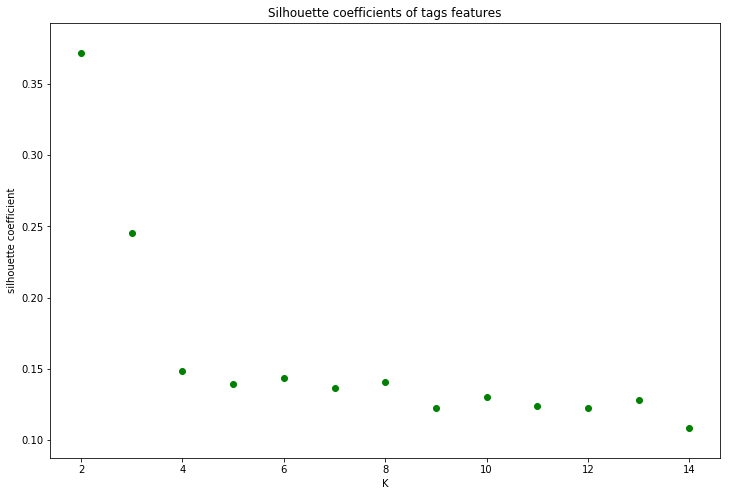

In [28]:
plt.figure(figsize=(12,8))
plt.title('Silhouette coefficients of tags features')
plt.xlabel('K')
plt.ylabel('silhouette coefficient')
plt.scatter(K, s, color='green')

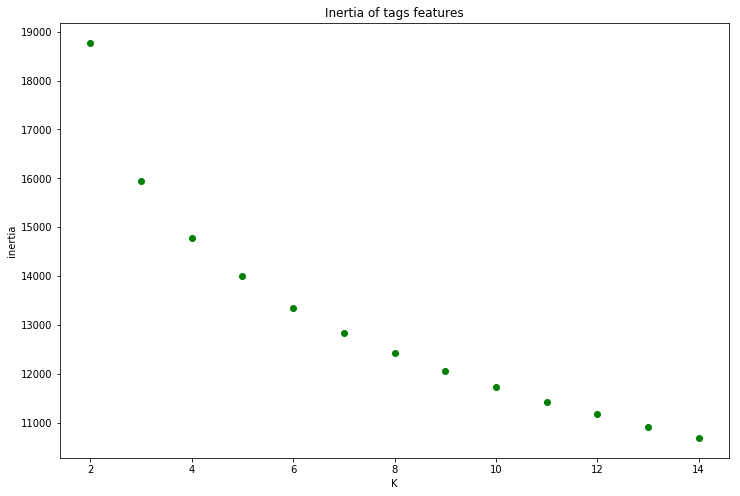

In [29]:
plt.figure(figsize=(12,8))
plt.title('Inertia of tags features')
plt.xlabel('K')
plt.ylabel('inertia')
plt.scatter(K, i, color='green')

In [30]:
K_tag = 4
kmeans = KMeans(n_clusters=K_tag, random_state=17, n_init=15, init='random').fit(tags[range(1,9)])
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

In [31]:
tags['cluster'] = labels

/home/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


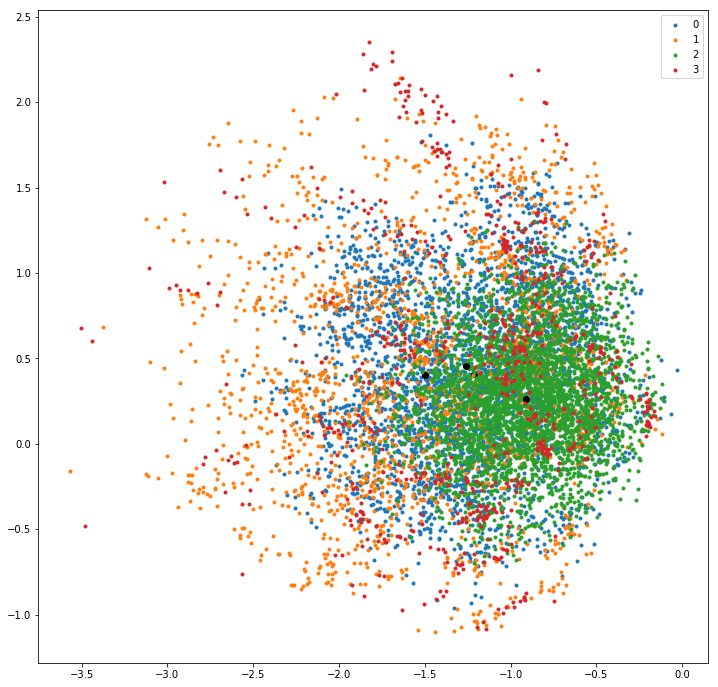

In [32]:
plotClusters(tags, K_tag, centroids)

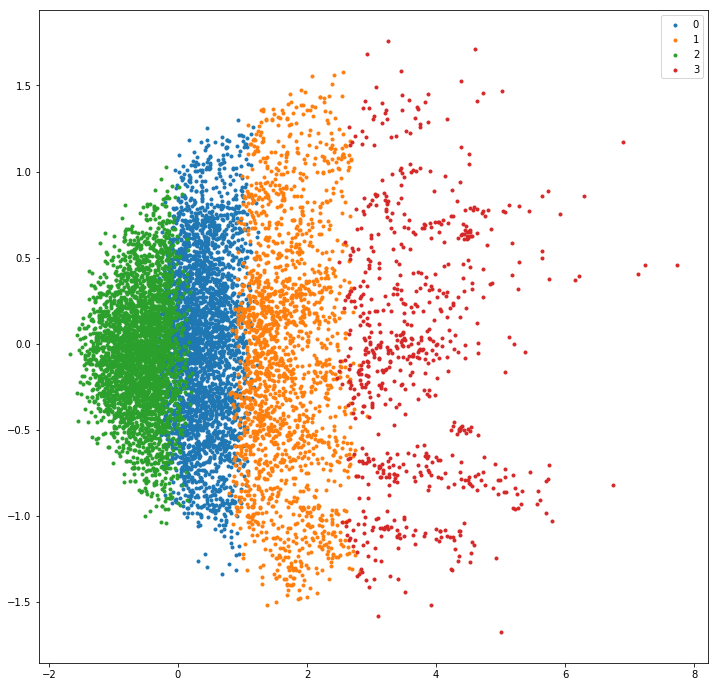

In [33]:
plotClusters(tags, K_tag, centroids, pcaComp=True)

In [34]:
with open('output/tags_clusters.txt', 'w') as outfile:
    for c in range(K_tag):
        cluster = tags[tags['cluster'] == c]
        
        outfile.write('Cluster {} - SIZE: {}\n'.format(c, cluster.shape[0]))
        outfile.write('\n'.join(list(cluster['content'])))
        outfile.write('\n')
        
        print c, cluster.shape[0]

0 3340
1 1884
2 3277
3 700


In [35]:
# add indegree to each tag, in order to extract top 10 tags for each cluster
network = snap.LoadEdgeListNet('data/followers_network.csv', '\t')

In [36]:
r = []
for tid in list(tags['id']):
    tid = int(tid)
    NI = network.GetNI(tid)
    indeg = NI.GetInDeg()
    
    r.append(tuple((tid, indeg)))
result = pd.DataFrame(r, columns=['id', 'indegree'])

In [37]:
tags_out = tags[['id', 'content', 'cluster']].merge(result, on='id')
tags_out.head()

,id,content,cluster,indegree
0,224700,tasselearrings,0,4
1,224701,gxgcollective,1,515
2,224702,australianbrand,1,237
3,224703,wanderlust,2,1290
4,224706,turquoise,2,15


In [38]:
# print top10 hashtags by frequency for each cluster
for c in range(K_tag):
    cluster = tags_out[tags_out['cluster'] == c]
    top10 = cluster.sort_values(by='indegree', ascending=False)[:10]
    print 'Cluster {}'.format(c)
    print top10[['content', 'indegree']]

Cluster 0
             content  indegree
121   interiordesign      2134
1636      california      2017
273           design      1966
858     luxurytravel      1790
330      amalficoast      1530
1777          foodie      1526
1049   travelblogger      1414
473             food      1208
1688             hat      1194
715           resort      1112
Cluster 1
                     content  indegree
7456               micheleLA      2191
2311             instadesign      1927
4272             fredbollaci      1815
4274  fredbollacienterprises      1695
4270            venumagazine      1511
4271                     ven      1510
4273                    venu      1476
3447                  decora      1415
421                homedecor      1349
7462               michelela      1347
Cluster 2
         content  indegree
265     handmade      1365
269  madeinitaly      1296
3     wanderlust      1290
105       luxury      1190
293  photography      1189
49      positano      1086
524        

Test using DBSCAN algorithm

In [61]:
db = DBSCAN(eps=0.3, min_samples=10, n_jobs=-1).fit(tags[range(1,9)])

In [62]:
labels = db.labels_

In [63]:
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_clusters

52

In [64]:
tags['dbscan'] = labels

/home/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


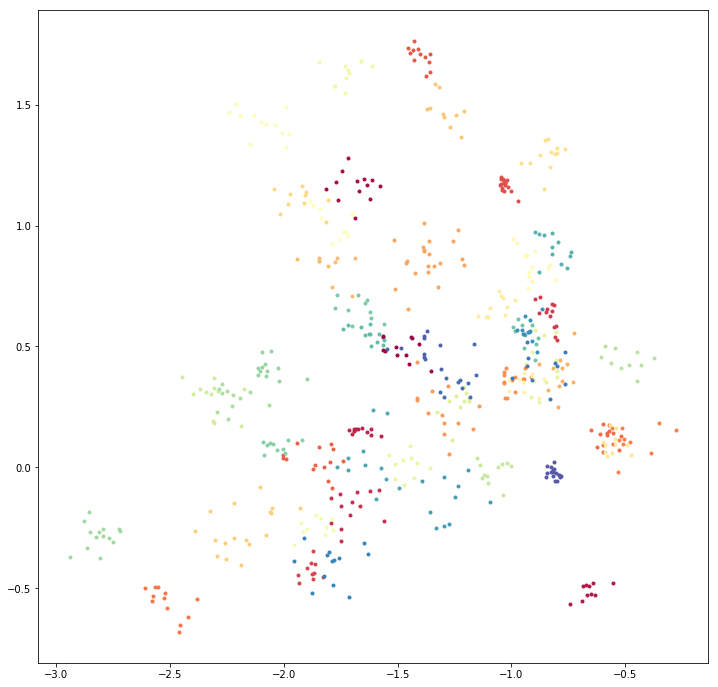

In [67]:
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]

plt.figure(figsize=(12,12))
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]
    else:
        cluster = tags[tags['dbscan'] == k]
        plt.scatter(cluster[1], cluster[2], marker='.', color=col)

In [70]:
sizes = []
for c in range(n_clusters):
    cluster = tags[tags['dbscan'] == c]
    sizes.append(cluster.shape[0])

<BarContainer object of 52 artists>

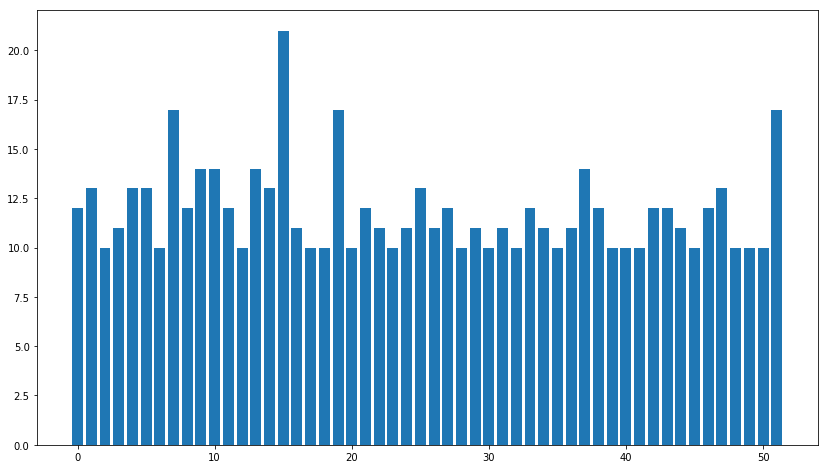

In [72]:
plt.figure(figsize=(14,8))
plt.bar(range(n_clusters), sizes)

In [74]:
sum(sizes)

616

In [78]:
tags[tags['dbscan'] == -1].shape[0]

8585

In [79]:
with open('output/clustering_tags.txt', 'w') as outfile:
    outfile.write('n_cluster\tdim\thashtags\n')
    for c in range(n_clusters):
        cluster = tags[tags['dbscan'] == c]
        outfile.write('{}\t{}\t{}\n'.format(c, cluster.shape[0], ','.join(list(cluster['content']))))

## 3. Cluster posts using features and define user participation

Extract feature vector of each post, cluster them, check the top hashtags (by frequency and common) to highlight the topics and then compute a participation index for each user in each of these clusters

In [39]:
posts.drop(['type',0], axis=1, inplace=True)

In [40]:
posts.shape

(223154, 13)

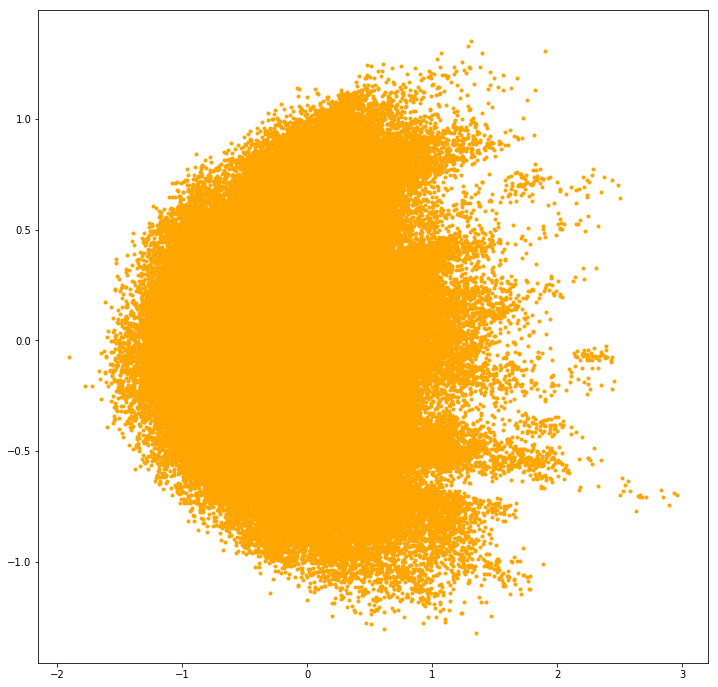

In [41]:
plt.figure(figsize=(12,12))
plt.scatter(posts['r1'], posts['r2'], marker='.', color='orange')

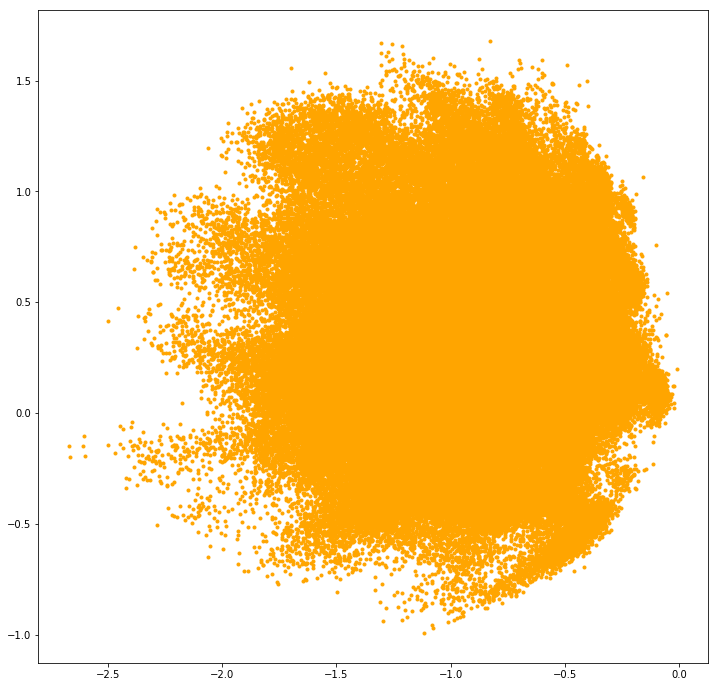

In [42]:
plt.figure(figsize=(12,12))
plt.scatter(posts[1], posts[2], marker='.', color='orange')

In [81]:
db = DBSCAN(eps=0.3, min_samples=10, n_jobs=-1).fit(posts[range(1,9)])

In [82]:
labels = db.labels_

In [83]:
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_clusters

198

In [84]:
posts['cluster'] = labels

/home/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


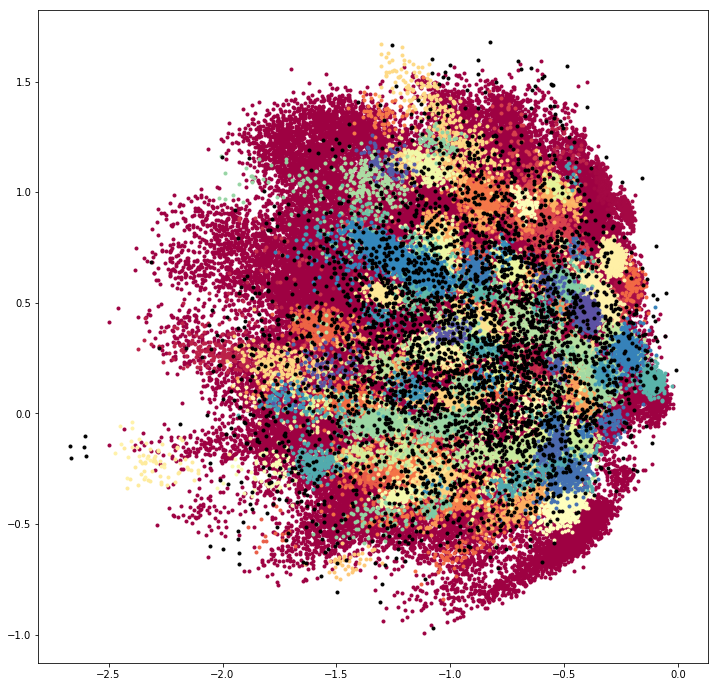

In [85]:
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]

plt.figure(figsize=(12,12))
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]
    cluster = posts[posts['cluster'] == k]
    plt.scatter(cluster[1], cluster[2], marker='.', color=col)

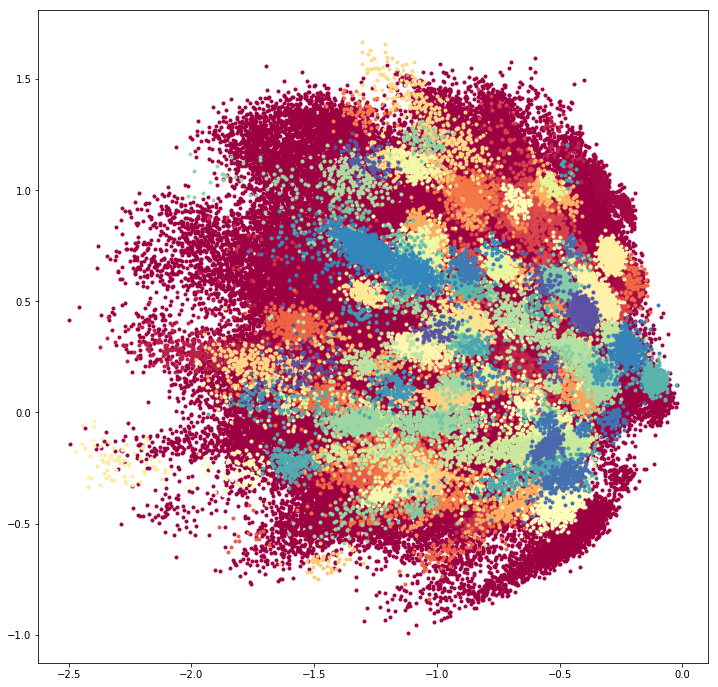

In [86]:
plt.figure(figsize=(12,12))
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]
    else:
        cluster = posts[posts['cluster'] == k]
        plt.scatter(cluster[1], cluster[2], marker='.', color=col)

In [87]:
sizes = []
for c in range(n_clusters):
    cluster = posts[posts['cluster'] == c]
    sizes.append(cluster.shape[0])

<BarContainer object of 197 artists>

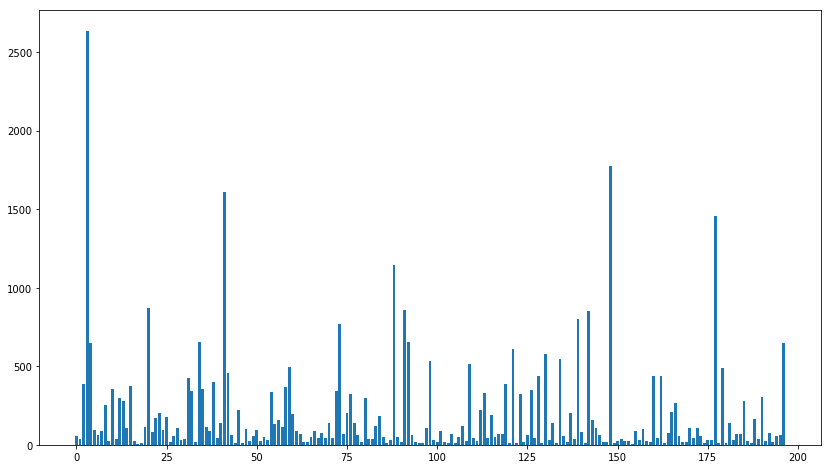

In [90]:
plt.figure(figsize=(14,8))
plt.bar(range(n_clusters-1), sizes[1:])

In [91]:
sum(sizes)

219483

In [94]:
posts[posts['cluster'] == 0].shape[0]

181693

In [93]:
posts[posts['cluster'] == -1].shape[0]

3671